<a href="https://colab.research.google.com/github/Ayon150/DIP_LAB/blob/main/DIP_ASSIGNMENT_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

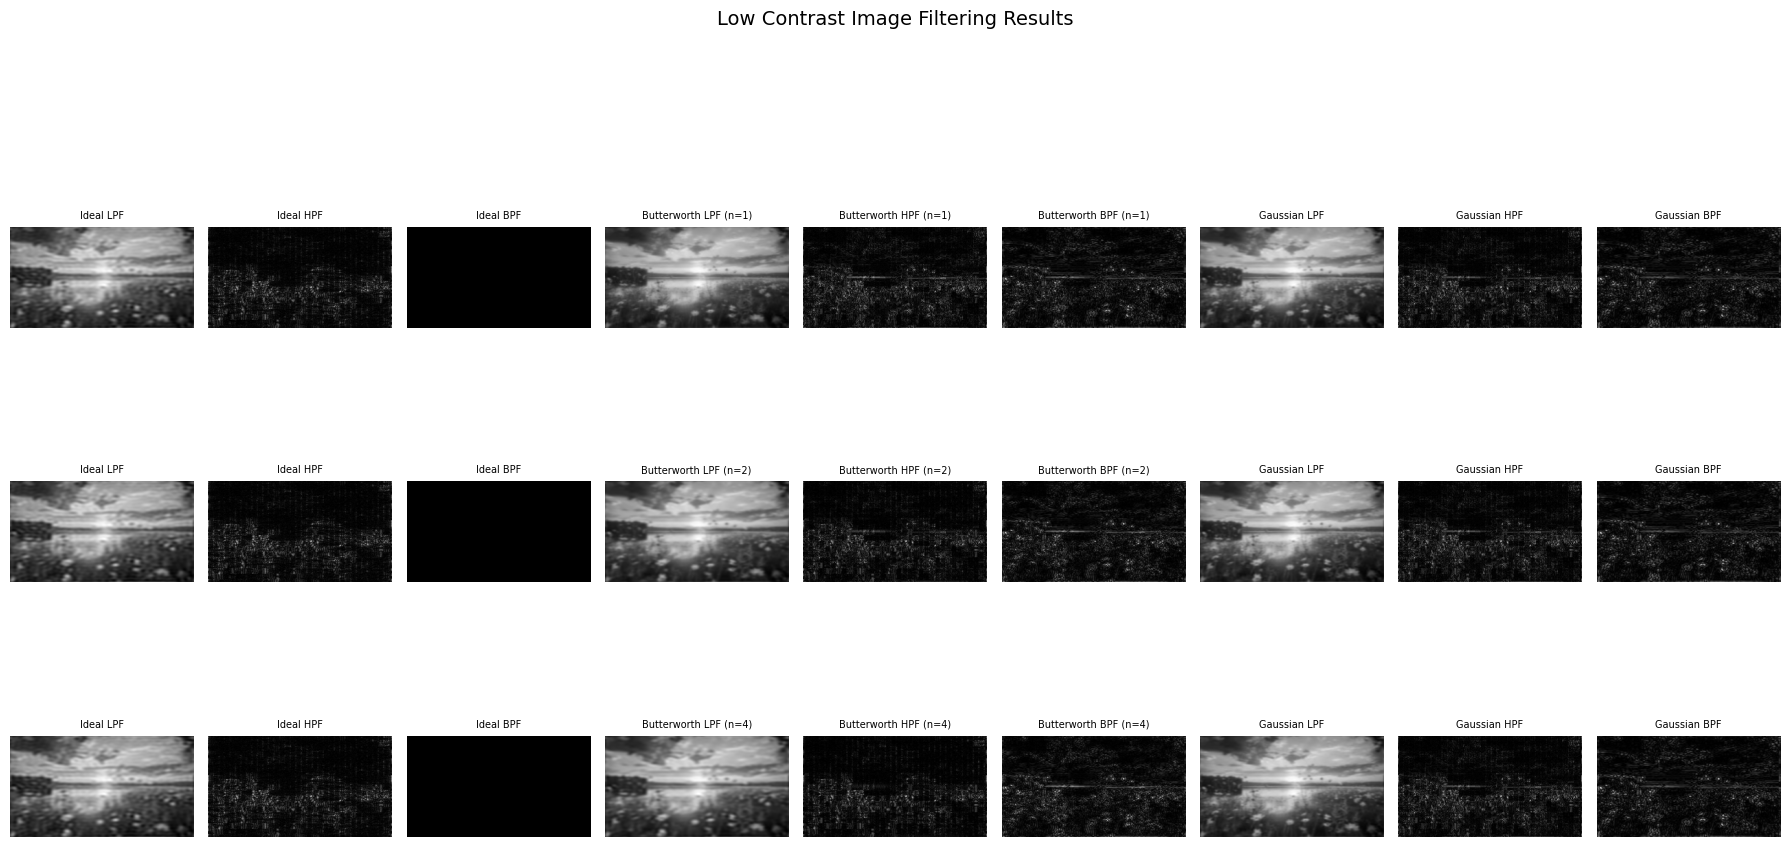

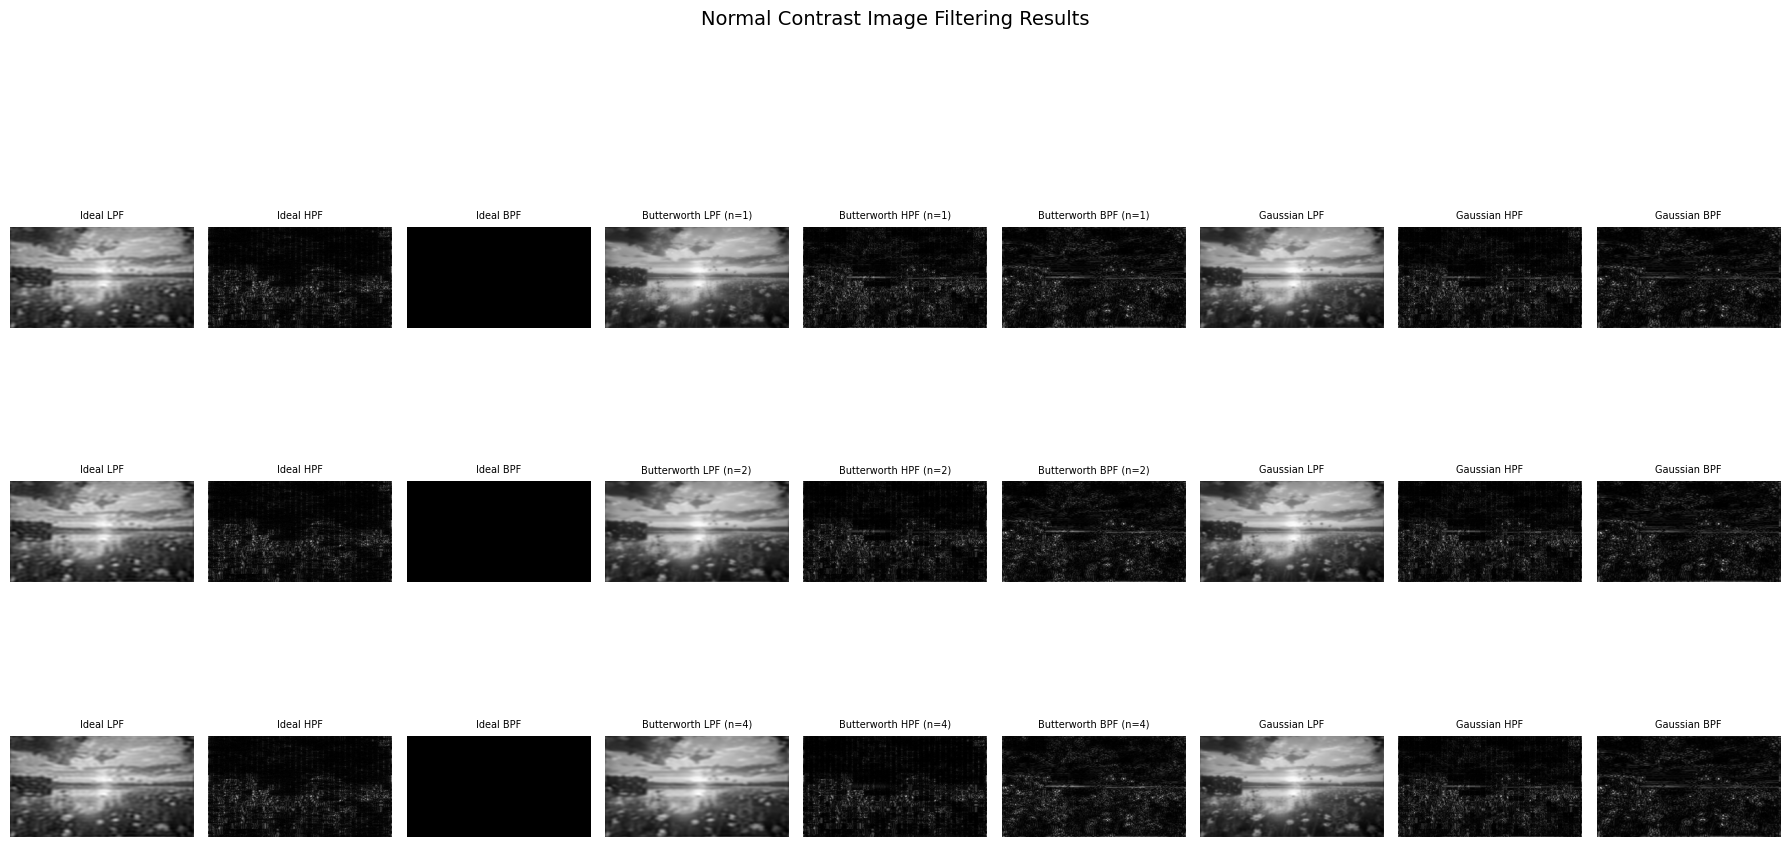

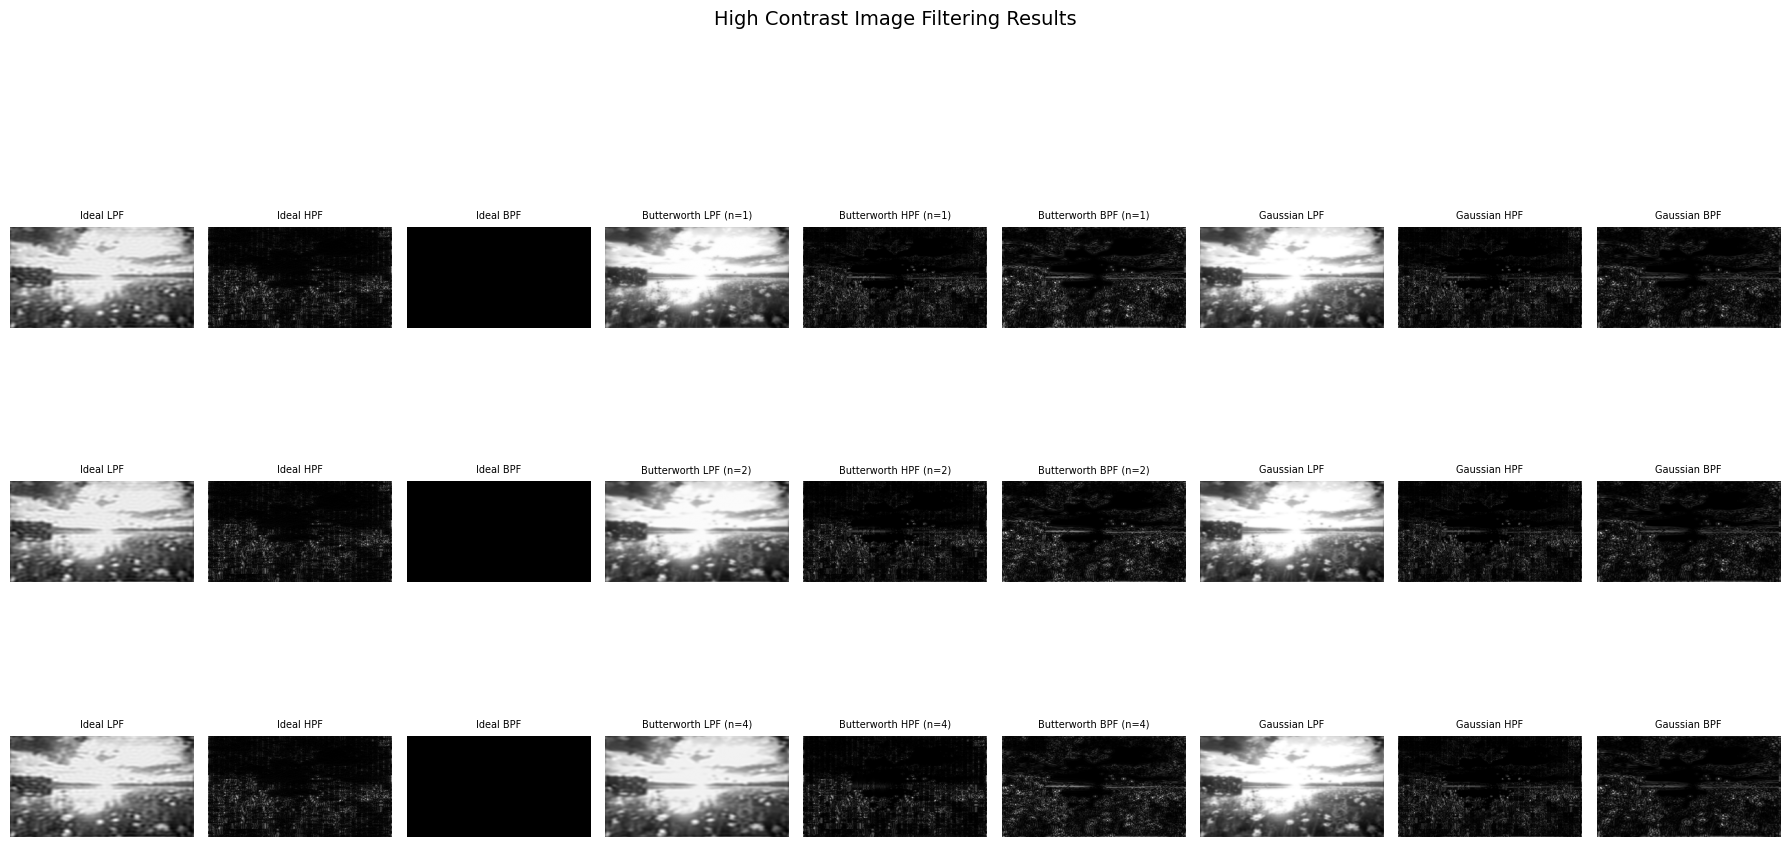

In [1]:
#===============================================
# Title: Frequency Domain Filtering Comparison
# Author: Ayon Kundu
# Description:
#   Applying Butterworth, Gaussian, and Ideal filters
#   (Low-pass, High-pass, Band-pass)
#   on images with different contrast levels.
#   Also compares different 'n' values for Butterworth filters.
#===============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import clear_output

#=================== Upload Image ===================#
print("📁 Please upload your image file...")
uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print(f"✅ Uploaded: {fn}")

#=================== Utility Functions ===================#

def adjust_contrast(img, alpha):
    """Adjust image contrast."""
    img_new = cv2.convertScaleAbs(img, alpha=alpha, beta=0)
    return img_new

def ideal_filter(shape, D0, filter_type):
    """Create an Ideal LPF or HPF."""
    P, Q = shape
    u, v = np.meshgrid(np.arange(Q), np.arange(P))
    D = np.sqrt((u - Q/2)**2 + (v - P/2)**2)
    if filter_type == 'low':
        H = (D <= D0).astype(np.float32)
    elif filter_type == 'high':
        H = (D > D0).astype(np.float32)
    return H

def butterworth_filter(shape, D0, n, filter_type):
    """Create a Butterworth LPF or HPF."""
    P, Q = shape
    u, v = np.meshgrid(np.arange(Q), np.arange(P))
    D = np.sqrt((u - Q/2)**2 + (v - P/2)**2)
    if filter_type == 'low':
        H = 1 / (1 + (D / D0)**(2*n))
    elif filter_type == 'high':
        H = 1 / (1 + (D0 / (D + 1e-5))**(2*n))
    return H

def gaussian_filter(shape, D0, filter_type):
    """Create a Gaussian LPF or HPF."""
    P, Q = shape
    u, v = np.meshgrid(np.arange(Q), np.arange(P))
    D = np.sqrt((u - Q/2)**2 + (v - P/2)**2)
    if filter_type == 'low':
        H = np.exp(-(D**2) / (2*(D0**2)))
    elif filter_type == 'high':
        H = 1 - np.exp(-(D**2) / (2*(D0**2)))
    return H

def apply_filter(img, H):
    """Apply filter in frequency domain."""
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    G = fshift * H
    g = np.fft.ifftshift(G)
    img_filtered = np.fft.ifft2(g)
    img_filtered = np.abs(img_filtered)
    return np.uint8(cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX))

def band_pass_filter(H_low, H_high):
    """Create Band-pass filter from LPF and HPF."""
    return H_high * H_low

#=================== Main Execution ===================#

def main():
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Image not found!")
        return

    # Contrast versions
    low_contrast = adjust_contrast(img, 0.5)
    normal_contrast = adjust_contrast(img, 1.0)
    high_contrast = adjust_contrast(img, 1.5)
    contrasts = {'Low': low_contrast, 'Normal': normal_contrast, 'High': high_contrast}

    D0_low = 30
    D0_high = 80
    n_values = [1, 2, 4]

    for contrast_name, image in contrasts.items():
        plt.figure(figsize=(18, 10))
        plt.suptitle(f"{contrast_name} Contrast Image Filtering Results", fontsize=14)

        for i, n in enumerate(n_values):
            # Butterworth Filters
            H_b_l = butterworth_filter(image.shape, D0_low, n, 'low')
            H_b_h = butterworth_filter(image.shape, D0_high, n, 'high')
            H_b_bp = band_pass_filter(H_b_l, H_b_h)

            img_b_l = apply_filter(image, H_b_l)
            img_b_h = apply_filter(image, H_b_h)
            img_b_bp = apply_filter(image, H_b_bp)

            # Gaussian Filters
            H_g_l = gaussian_filter(image.shape, D0_low, 'low')
            H_g_h = gaussian_filter(image.shape, D0_high, 'high')
            H_g_bp = band_pass_filter(H_g_l, H_g_h)

            img_g_l = apply_filter(image, H_g_l)
            img_g_h = apply_filter(image, H_g_h)
            img_g_bp = apply_filter(image, H_g_bp)

            # Ideal Filters
            H_i_l = ideal_filter(image.shape, D0_low, 'low')
            H_i_h = ideal_filter(image.shape, D0_high, 'high')
            H_i_bp = band_pass_filter(H_i_l, H_i_h)

            img_i_l = apply_filter(image, H_i_l)
            img_i_h = apply_filter(image, H_i_h)
            img_i_bp = apply_filter(image, H_i_bp)

            # Show results
            filters = [img_i_l, img_i_h, img_i_bp,
                       img_b_l, img_b_h, img_b_bp,
                       img_g_l, img_g_h, img_g_bp]
            titles = [f'Ideal LPF', f'Ideal HPF', f'Ideal BPF',
                      f'Butterworth LPF (n={n})', f'Butterworth HPF (n={n})', f'Butterworth BPF (n={n})',
                      f'Gaussian LPF', f'Gaussian HPF', f'Gaussian BPF']

            for j in range(9):
                plt.subplot(len(n_values), 9, i*9 + j + 1)
                plt.imshow(filters[j], cmap='gray')
                plt.title(titles[j], fontsize=7)
                plt.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Run main
clear_output(wait=True)
main()
